# Question 1


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config

set_config(display='diagram')

loans = pd.read_excel('../data/loans.xlsx', index_col=0)
loans.loc[:, 'issue_yr'] = loans.issue_d.apply(lambda x: x.year)
loans.loc[:, 'issue_mth'] = loans.issue_d.apply(lambda x: x.month)
drop_these_columns = loans.apply(lambda x: np.sum(pd.notna(x)), axis=0) < 40000
loans.drop(columns=loans.columns[drop_these_columns], inplace=True)
no_miss = loans[pd.notna(loans).all(axis=1)].copy()
cr_line_cols = no_miss.earliest_cr_line.str.split('-', expand=True)
cr_line_cols.columns = ['ecrl_mth', 'ecrl_yr']
cr_line_cols.ecrl_yr = cr_line_cols.ecrl_yr.astype(int)
no_miss = pd.concat([no_miss, cr_line_cols], axis=1)
y = no_miss.y
X_train, X_test, y_train, y_test = train_test_split(no_miss, y, test_size=0.3, random_state=41, stratify=y)

num_features = ['loan_amnt', 'int_rate', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'issue_yr']
cat_features = ['term', 'grade', 'emp_length', 'home_ownership', 'loan_status', 'purpose', 'addr_state']
all_features = num_features + cat_features
X_train = X_train.loc[:, all_features]
X_test = X_test.loc[:, all_features]
ct = ColumnTransformer([
      ('scale', StandardScaler(), make_column_selector(dtype_include=np.number)),
      ('onehot', OneHotEncoder(), make_column_selector(dtype_include=object))])
ct.fit(X_train)
X_ttrain = ct.transform(X_train)
X_ttest = ct.transform(X_test)

1. A logistic regression classifier is a widely used classification model. It models the log-odds for a class as a linear combination of one or more independent variables. **With L2 regularization,** the hyper-parameter is C, the inverse of regularization strength. Create a sklearn logistic regression classifier with L2 regularization, `random_state=42` and `solver='saga'`, then generate and plot the validation curve by varying C over the range from 1 to 3001 (inclusive of both endpoints) with at least 16 different values.
2. Apply the best estimator to the *test set*, and compare the confusion matrix to the KNN model. In class, it achieved an accuracy of 0.89 and an F1-score of 0.58.

**Question 1.1:**

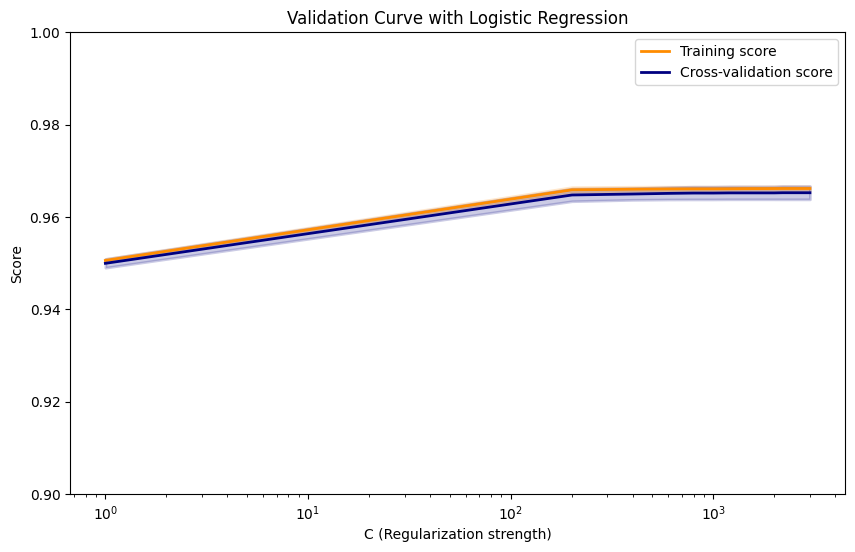

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

logreg = LogisticRegression(penalty='l2', random_state=42, solver='saga', max_iter=1000)

C_values = np.linspace(1, 3001, 16)

train_scores, test_scores = validation_curve(
    logreg, X_ttrain, y_train, param_name="C", param_range=C_values, cv=5, scoring="accuracy")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("C (Regularization strength)")
plt.ylabel("Score")

plt.ylim(0.9, 1)
plt.semilogx(C_values, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.fill_between(C_values, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=2)
plt.semilogx(C_values, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(C_values, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=2)
plt.legend(loc="best")
plt.show()

**Question 1.2:**

In [3]:
max_score_index = np.argmax(test_scores_mean)
best_C = C_values[max_score_index]
print('Best C value: ',best_C)
print('Best test set scores: ', test_scores_mean[max_score_index])

Best C value:  2201.0
Best test set scores:  0.9652357235855551


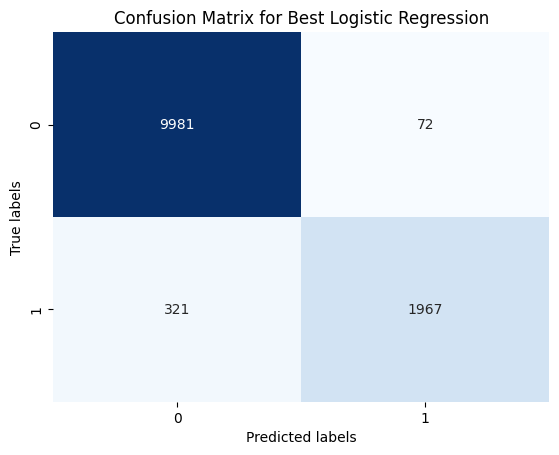

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
best_logreg = LogisticRegression(penalty='l2', C=best_C, random_state=42, solver='saga', max_iter=1000)
best_logreg.fit(X_ttrain, y_train)

y_pred_logreg = best_logreg.predict(X_ttest)

conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

sns.heatmap(conf_matrix_logreg, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Best Logistic Regression')
plt.show()

In [5]:
knn_results = {
    "accuracy": 0.89,
    "f1_score": 0.58
}

logreg_results = {
    "accuracy": accuracy_logreg,
    "f1_score": f1_logreg
}

print('KNN Results: ', knn_results)
print('Best Logistic Regression Results:', logreg_results)

KNN Results:  {'accuracy': 0.89, 'f1_score': 0.58}
Best Logistic Regression Results: {'accuracy': 0.9681549307187424, 'f1_score': 0.9091749480009245}


# Question 2

Insert other cells after this next cell and fill in the codes you use to detect the objects in `train_station_bournemouth.jpg` and report all the labels detected and how many objects there were of each label.

Detected labels and counts:
backpack: 12
handbag: 9
person: 58
suitcase: 9
train: 6


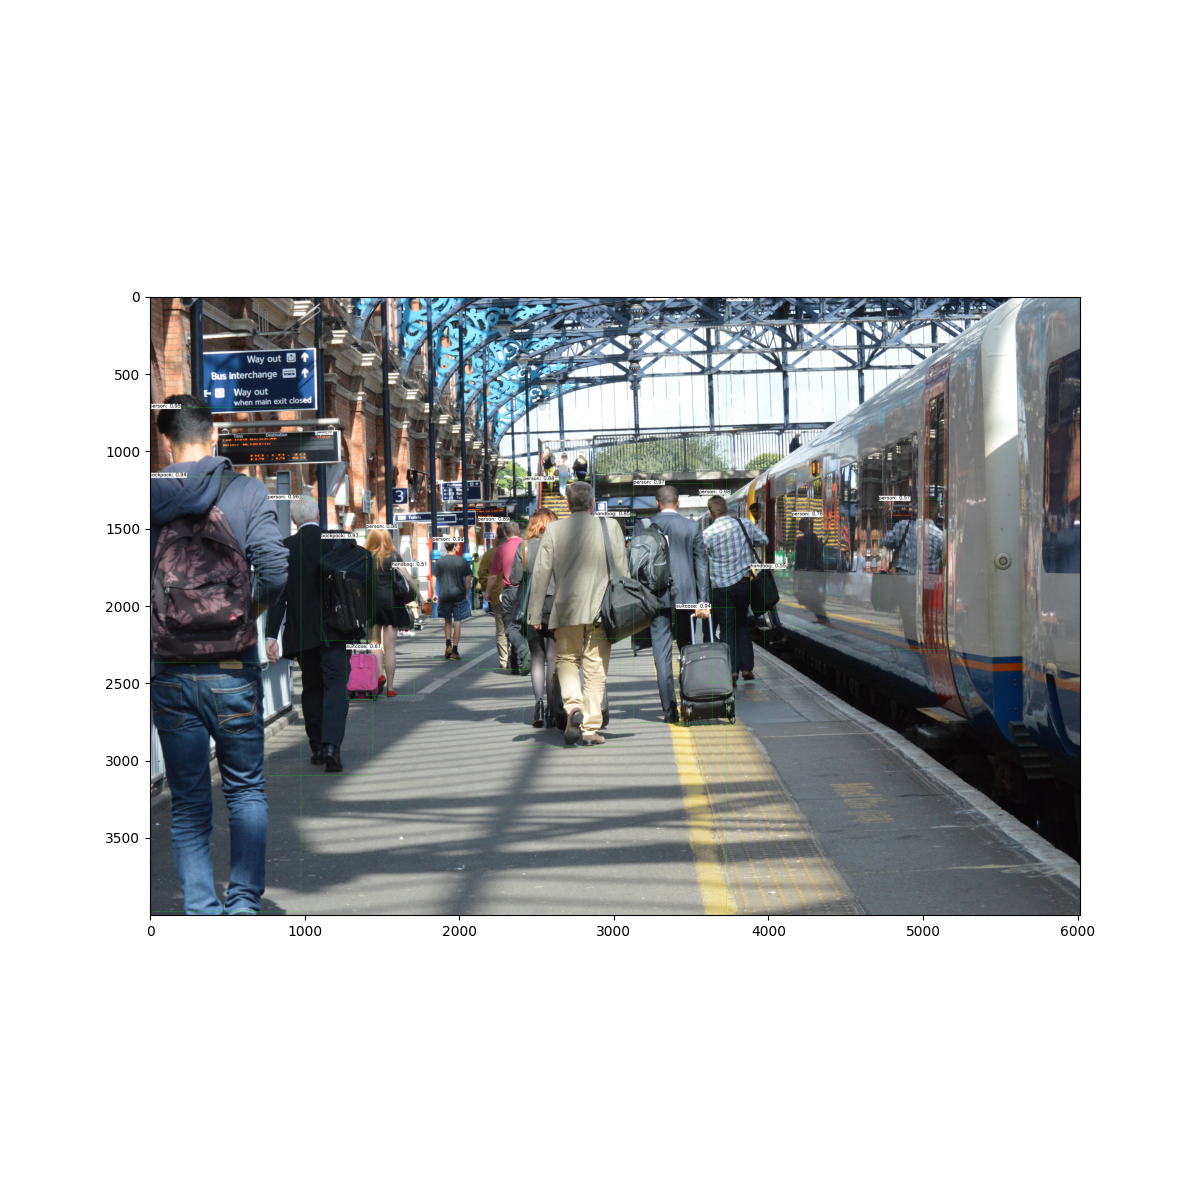

In [6]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
%matplotlib widget
import myscripts.vision as vs
import importlib

nn = cv.dnn.readNet('yolov4.weights', 'yolov4.cfg')

with open('opencv-4.x/samples/data/dnn/object_detection_classes_yolov4.txt', 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
f1 = cv.imread('../data/train_station_bournemouth.jpg')
blob = cv.dnn.blobFromImage(f1, size=(416, 416), swapRB=True, ddepth=cv.CV_8U)
nn.setInput(blob, scalefactor=0.00392 )
outs = nn.forward(nn.getUnconnectedOutLayersNames())
importlib.reload(vs);
vs.postprocess(f1, outs, classes, nn)
plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(f1, cv.COLOR_BGR2RGB))